In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import seaborn as sns
import joblib

In [2]:
import shutil

src_dir = r"C:\Users\Vikram\Desktop\Vikram\Internship\Task 3\train"
cat_dir = os.path.join(src_dir, 'cat')
dog_dir = os.path.join(src_dir, 'dog')

# Create directories if they don't exist
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Move files
for file in os.listdir(src_dir):
    if file.startswith("cat") and file.endswith(".jpg"):
        shutil.move(os.path.join(src_dir, file), os.path.join(cat_dir, file))
    elif file.startswith("dog") and file.endswith(".jpg"):
        shutil.move(os.path.join(src_dir, file), os.path.join(dog_dir, file))

print("Images organized into cat/ and dog/ folders.")


Images organized into cat/ and dog/ folders.


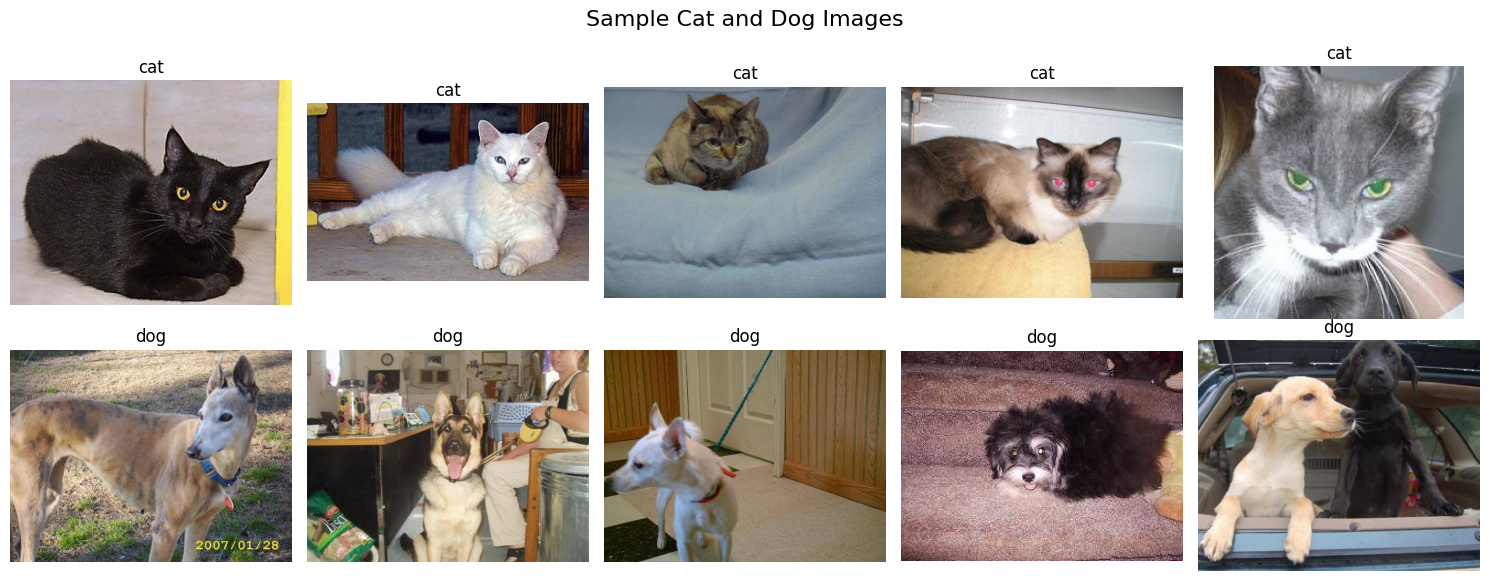

In [24]:
import random

def load_sample_images(data_dir, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle('Sample Cat and Dog Images', fontsize=16)

    for i, animal in enumerate(['cat', 'dog']):
        animal_dir = os.path.join(data_dir, animal)
        images = os.listdir(animal_dir)
        selected_images = random.sample(images, num_samples)

        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(animal_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(animal)

    plt.tight_layout()
    plt.show()

# Your original line
data_dir = r"C:\Users\Vikram\Desktop\Vikram\Internship\Task 3\train"
load_sample_images(data_dir)


In [8]:
def load_and_preprocess_data(data_dir, sample_size=2000, img_size=(64, 64)):
    """Load and preprocess cat and dog images"""
    categories = ['cat', 'dog']
    images = []
    labels = []
    
    print(f"Loading {sample_size} images ({sample_size//2} per class)...")
    
    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)
        count = 0
        
        for img_name in tqdm(os.listdir(path)[:sample_size//2]):
            try:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
                img = cv2.resize(img, img_size)  # Resize to consistent dimensions
                images.append(img)
                labels.append(class_num)
                count += 1
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

# Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    print(f"\nSuccessfully loaded {len(images)} images")
    print(f"Cat images: {np.sum(labels == 0)}")
    print(f"Dog images: {np.sum(labels == 1)}")
    
    return images, labels
images, labels = load_and_preprocess_data(data_dir, sample_size=2000)

# Display the shape of our data
print("\nImages shape:", images.shape)
print("Labels shape:", labels.shape)

Loading 2000 images (1000 per class)...


  0%|          | 5/1000 [00:00<00:20, 48.99it/s]

100%|██████████| 1000/1000 [00:03<00:00, 287.25it/s]


Successfully loaded 2000 images
Cat images: 1000
Dog images: 1000

Images shape: (2000, 64, 64)
Labels shape: (2000,)


Text(0, 0.5, 'Frequency')

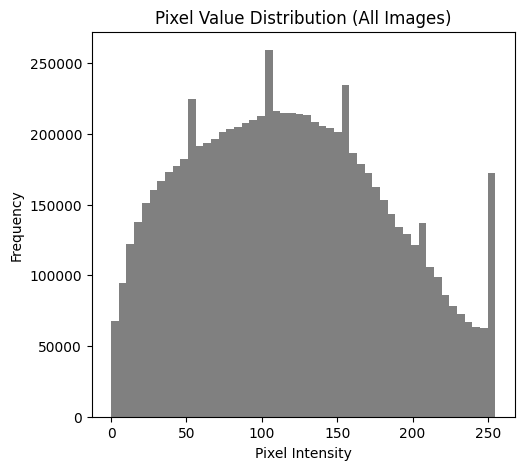

In [12]:
# Flatten all images for histogram
all_pixels = images.flatten()

# Plot histograms
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(all_pixels, bins=50, color='gray')
plt.title('Pixel Value Distribution (All Images)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

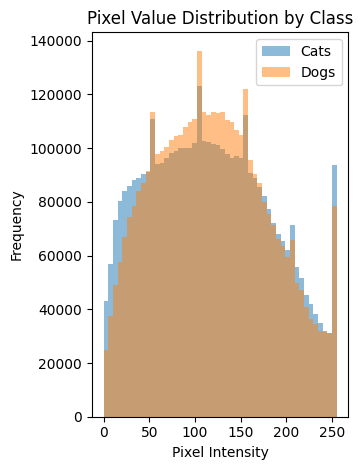

In [13]:
plt.subplot(1, 2, 2)
plt.hist(images[labels == 0].flatten(), bins=50, alpha=0.5, label='Cats')
plt.hist(images[labels == 1].flatten(), bins=50, alpha=0.5, label='Dogs')
plt.title('Pixel Value Distribution by Class')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

Training set shape: (1600, 4096)
Test set shape: (400, 4096)
Fitting PCA...

After PCA:
Training set shape: (1600, 100)
Test set shape: (400, 100)


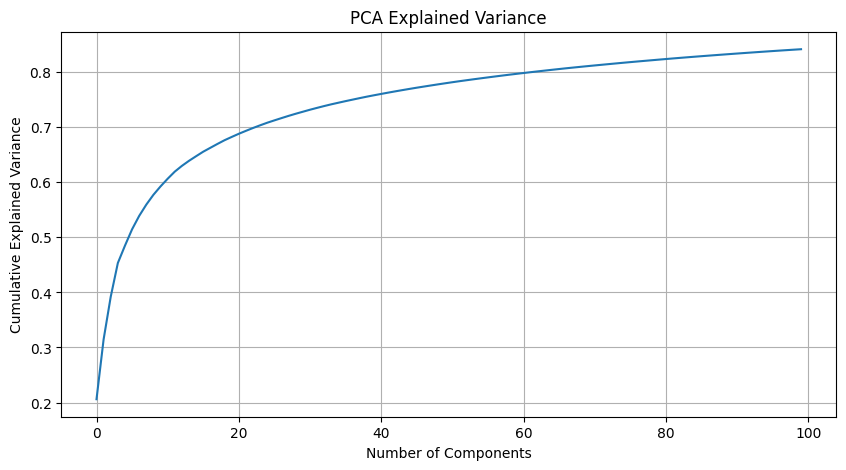

In [15]:
n_samples = len(images)
X = images.reshape((n_samples, -1))  # Flatten each image
X = X / 255.0  # Normalize pixel values to [0, 1]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=100)  # Reduce to 100 principal components
print("Fitting PCA...")
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\nAfter PCA:")
print(f"Training set shape: {X_train_pca.shape}")
print(f"Test set shape: {X_test_pca.shape}")

# Plot explained variance ratio
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

Training SVM...
Training complete!
Accuracy: 58.25%

Classification Report:
              precision    recall  f1-score   support

         cat       0.58      0.62      0.60       200
         dog       0.59      0.55      0.57       200

    accuracy                           0.58       400
   macro avg       0.58      0.58      0.58       400
weighted avg       0.58      0.58      0.58       400



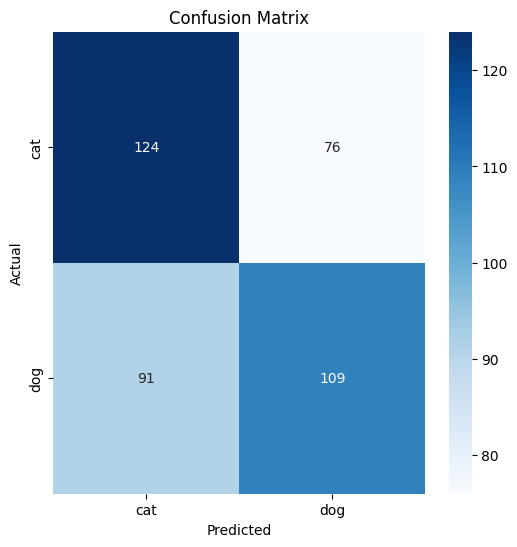

In [16]:
print("Training SVM...")
svm = SVC(kernel='rbf', C=10, gamma=0.001, random_state=42)
svm.fit(X_train_pca, y_train)

print("Training complete!")
y_pred = svm.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['cat', 'dog']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [17]:
joblib.dump(svm, 'cat_dog_svm.pkl')
joblib.dump(pca, 'pca.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Models saved successfully!")
svm = SVC(kernel='rbf', C=10, gamma=0.001, random_state=42, probability=True)  # Add this parameter
svm.fit(X_train_pca, y_train)

Models saved successfully!


SVC(C=10, gamma=0.001, probability=True, random_state=42)

Cat example:


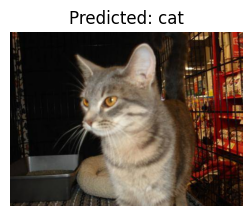


Dog example:


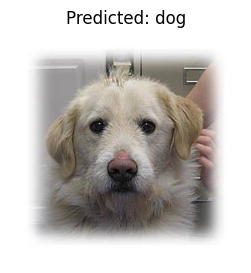

In [19]:
def predict_and_show(image_path, model, pca, scaler, img_size=(64, 64)):
    """Predict and display cat/dog image with result"""
    # Read and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read {image_path}")
        return
    
    # Convert to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Process for prediction (grayscale)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, img_size)
    img_flat = img_resized.flatten() / 255.0
    img_scaled = scaler.transform([img_flat])
    img_pca = pca.transform(img_scaled)
    
    # Make prediction
    prediction = model.predict(img_pca)[0]
    animal = "cat" if prediction == 0 else "dog"
    
    # Try to get confidence score
    try:
        proba = model.predict_proba(img_pca)[0]
        confidence = max(proba)
    except:
        confidence = None
    
    # Display results
    plt.figure(figsize=(3,3))
    plt.imshow(img_rgb)
    plt.axis('off')
    title = f"Predicted: {animal}"
    if confidence:
        title += f" ({confidence:.1%})"
    plt.title(title)
    plt.show()
test_cat = r"C:\Users\Vikram\Desktop\Vikram\Internship\Task 3\test1\1988.jpg"
test_dog = r"C:\Users\Vikram\Desktop\Vikram\Internship\Task 3\test1\3.jpg"


# Load models (do this once)
svm_model = joblib.load('cat_dog_svm.pkl')
pca = joblib.load('pca.pkl')
scaler = joblib.load('scaler.pkl')

# Predict and show both examples
print("Cat example:")
predict_and_show(test_cat, svm_model, pca, scaler)

print("\nDog example:")
predict_and_show(test_dog, svm_model, pca, scaler)